<a href="https://colab.research.google.com/github/robotmasterkris/case_study/blob/main/TLAQ_Reference_Module_5_Research_Session_1_Equity_Index_VRP_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis Techniques Covered

What we're going cover

* Uncovering assumptions
* Creating testable hypotheses
* Trying to disprove them
** Getting data
** Plotting time-series charts
** Munging and reshaping data
** Plotting distributions and Stationarity
** Scatterplots
** Correlograms
** Exploratory analysis

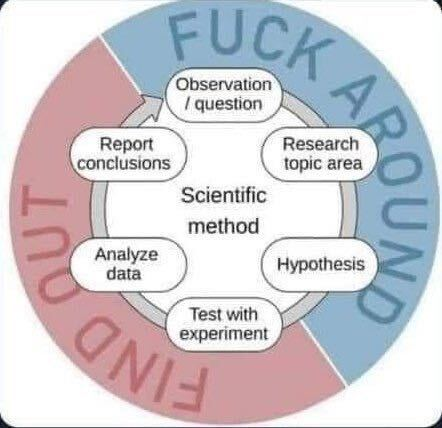

# Equity Implied Volatility Dynamics

## The Power of the world "Bullshit"

(Be a bit unreasonable)

Overheard: "Volatility has been realizing above (below) implied. A good time to buy (sell) vol."

Your response: "Bullshit"

## Uncover assumptions

What assumptions are being made?

- That vol realizing above implied is a good indication of options being cheap (I think it is)
- That if vol has been realizing above implied, it's likely to keep happening for a while (hmmm....)

We shouldn't assume that tradeable conditions persist like this.

If they did it would be easy to make money. And it tends not to be. So let's investigate.

## Research is not coding or backtesting

Many people, when confronted with how to look at something like this, jump straight to the end. They would try to do a backtest simulation of a trading strategy and see if it makes money. That's usually a bad idea.

Backtesting is complicated (especially for something like this) and tends to be subject to a lot of arbitrary decisions, luck and path dependency.

You want to move quickly and use the data more efficiently than that, in a less opinionated way. You want to do basic data analysis.

# New Section

# Run this to install the library dependencies we need


In [1]:
install.packages('tidyverse')
library(tidyverse)
library(lubridate)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Quick Intro to the Notebook Environment

* objects, functions, running code
* the pipe operator

In [2]:
a <- 10
vec <- c(1,2,3)

In [3]:
ls()

[1] "a"   "vec"

In [4]:
max(vec)
min(vec)

[1] 3

[1] 1

In [5]:
vec %>% max() %>% sum(2)

[1] 5

# Getting Data

We want the following data:
* ATM IV of 30 DTE SPX options (interpolated)
* SPX daily returns (for calculating 30 day realized volatility)


Often it's a bit of work to get what we want, so we start with the closest thing to it that's easy for us to get.

Moving fast is important. We can disprove things easier than we can prove them. We can always loop back.

Aiming for the perfect data upfront is a fools errand. Strive first to get moving, and to understand the ways in which your data might be biased.

## The closest eaasily available data

* VIX index from cboe
* Realized vol calculated from SPY returns


## VIX Data from CBOE



https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv

In [6]:
VIX <- read_csv('https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv')


Rows: 8773 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): DATE
dbl (4): OPEN, HIGH, LOW, CLOSE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
ls()

[1] "a"   "vec" "VIX"

In [8]:
VIX %>% tail()

DATE,OPEN,HIGH,LOW,CLOSE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
10/01/2024,16.96,20.73,16.61,19.26
10/02/2024,19.65,20.36,18.58,18.90
10/03/2024,19.63,20.75,19.16,20.49
10/04/2024,20.48,20.48,18.48,19.21
10/07/2024,20.76,23.03,20.65,22.64
10/08/2024,22.92,23.14,21.14,21.42


We always want to think about the shape of the data. What is a row / what is a column?

In this case:
* A row represents a day's observations for the VIX index
* The columns represent the opening, high, low and close of the day. (We mostly only care about the close).

The first thing we notice is that our date hasn't come across as sommething R is recognizing as a date.

We can force it to be a date using lubridate's mdy function.

`mutate()` is the function we use to change or add rows to our data.

In [36]:
VIX <- VIX %>%
  mutate(DATE = lubridate::mdy(DATE))

VIX %>% tail()

DATE,OPEN,HIGH,LOW,CLOSE
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2024-10-01,16.96,20.73,16.61,19.26
2024-10-02,19.65,20.36,18.58,18.90
2024-10-03,19.63,20.75,19.16,20.49
2024-10-04,20.48,20.48,18.48,19.21
2024-10-07,20.76,23.03,20.65,22.64
2024-10-08,22.92,23.14,21.14,21.42


Every time we get a new dataset we want to plot it to make sure it looks like we expect.

(Google is your friend for ggplot2 syntax. Google "ggplot line chart")

In [ ]:
2

[1] 2

If you are familiar with VIX, you'll recognize this.

You can recognize the big events.

Unlike tradeable financial assets you might see, VIX does not drift. A 20 level on VIX means the same thing in 1990 as it does in 2020.

Let's plot the distribution as a histogram.

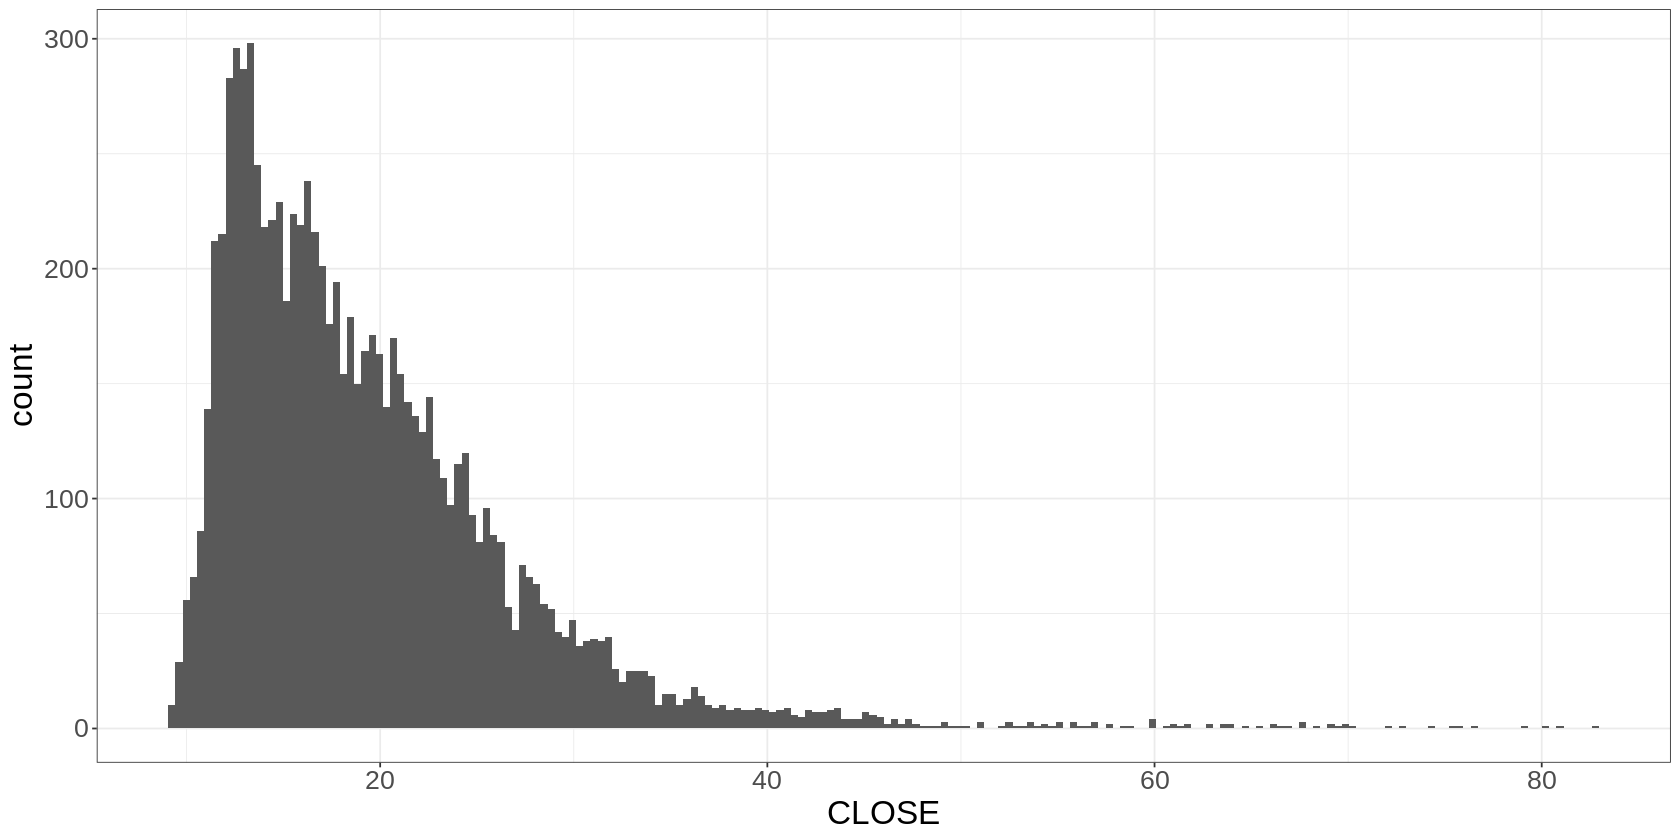

In [9]:
VIX %>%
  ggplot(aes(x=CLOSE)) + geom_histogram(bins = 200)

VIX is very positively skewed.

If we think VIX is "stationary", what we're really saying is we're pulling it from the same hat each time.

We can split our data by decade in two, and see how similar the distributions look.

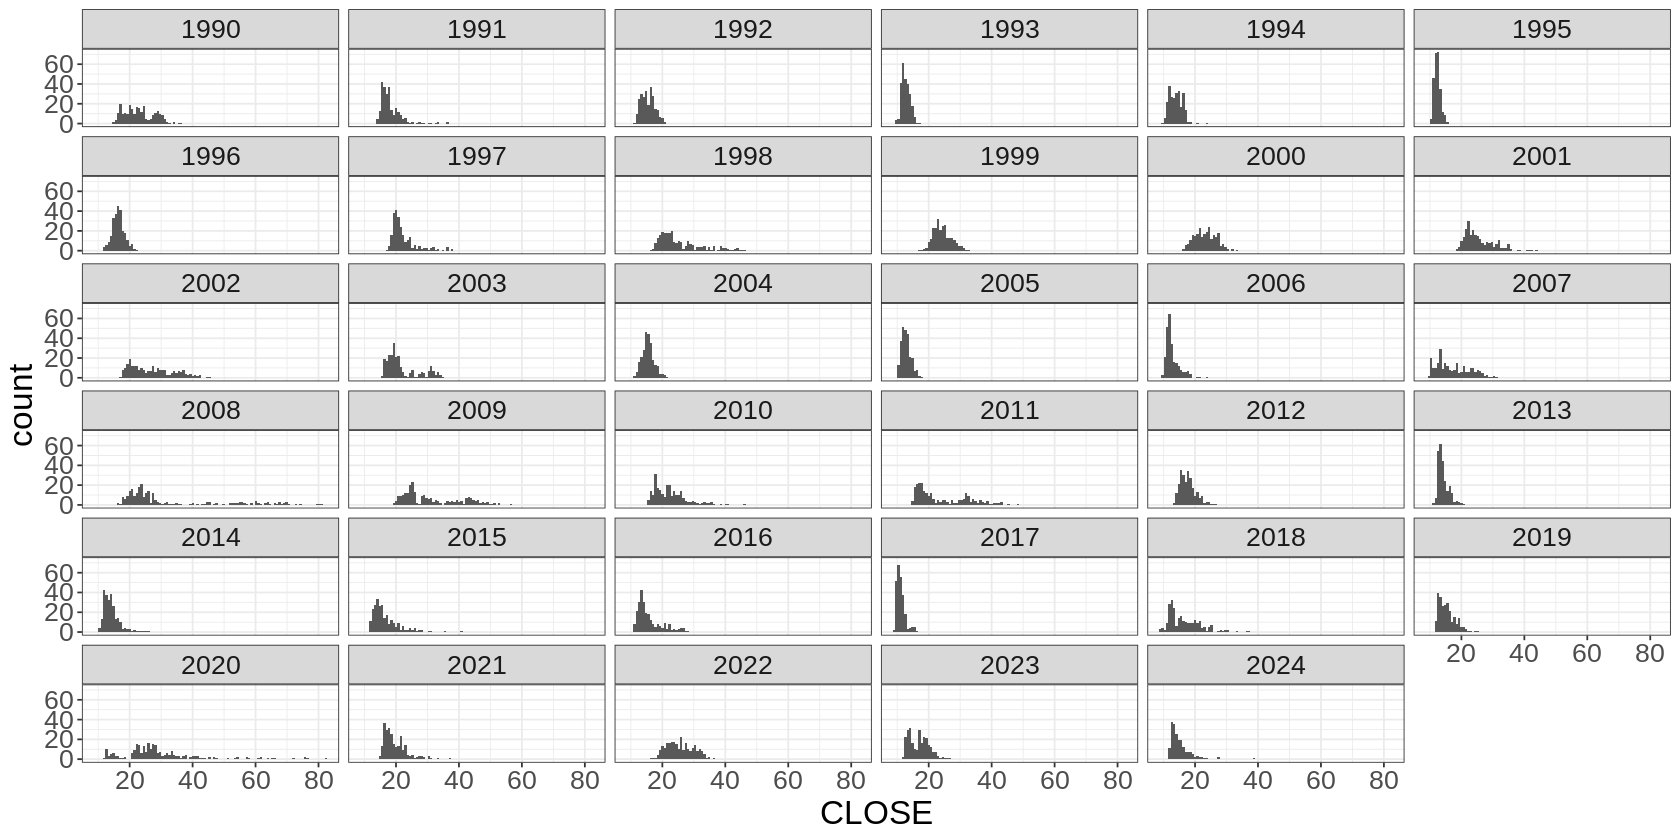

In [37]:
VIX %>%
  mutate(yeartoanalyze = year(DATE) - year(DATE) %% 1) %>%
  ggplot(aes(x=CLOSE)) +
    geom_histogram(bins = 100) +
    facet_wrap(~yeartoanalyze)


### Understanding bias in our data

VIX is a variance swap calculation. Variance is highly positively skewed. So selling variance attracts a risk premium. VIX will therefore be biased higher than ATM implied volatility.

We're not very worried about this because we expect it to be consistent across all our data.

## Get SPY data

SPX data is a bit annoying to get from free sources.

Let's get SPY data from yahoo finance, which will be more than good enuff for what we want to do here.

In [15]:
# this query currently doesn't work as Yahoo have changed something
# SPY <- read_csv('https://query1.finance.yahoo.com/v7/finance/download/SPY?period1=728352000&period2=1721779200&interval=1d&events=history&includeAdjustedClose=true')

Use quantmod instead

In [12]:
install.packages("quantmod")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’




In [23]:
library(quantmod)

getSymbols("SPY", src = "yahoo", from = as.Date("1993-01-01"), to = as.Date("2024-10-01"))
head(SPY)

[1] "SPY"

           SPY.Open SPY.High  SPY.Low SPY.Close SPY.Volume SPY.Adjusted
1993-01-29 43.96875 43.96875 43.75000  43.93750    1003200     24.60862
1993-02-01 43.96875 44.25000 43.96875  44.25000     480500     24.78366
1993-02-02 44.21875 44.37500 44.12500  44.34375     201300     24.83617
1993-02-03 44.40625 44.84375 44.37500  44.81250     529400     25.09869
1993-02-04 44.96875 45.09375 44.46875  45.00000     531500     25.20371
1993-02-05 44.96875 45.06250 44.71875  44.96875     492100     25.18621

In [24]:
SPY <- data.frame(Date = index(SPY), coredata(SPY))

SPY <- SPY %>%
  rename_with(~ gsub("^SPY\\.", "", .)) %>%
  rename("Adj Close" = Adjusted)

SPY %>% head

,Date,Open,High,Low,Close,Volume,Adj Close
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1993-01-29,43.96875,43.96875,43.75000,43.93750,1003200,24.60862
2,1993-02-01,43.96875,44.25000,43.96875,44.25000,480500,24.78366
3,1993-02-02,44.21875,44.37500,44.12500,44.34375,201300,24.83617
4,1993-02-03,44.40625,44.84375,44.37500,44.81250,529400,25.09869
5,1993-02-04,44.96875,45.09375,44.46875,45.00000,531500,25.20371
6,1993-02-05,44.96875,45.06250,44.71875,44.96875,492100,25.18621


This time it's recognized our date.

Again:
 - row: daily observation for SPY
 - column: ohlcv and adj close observation

Let's plot it.

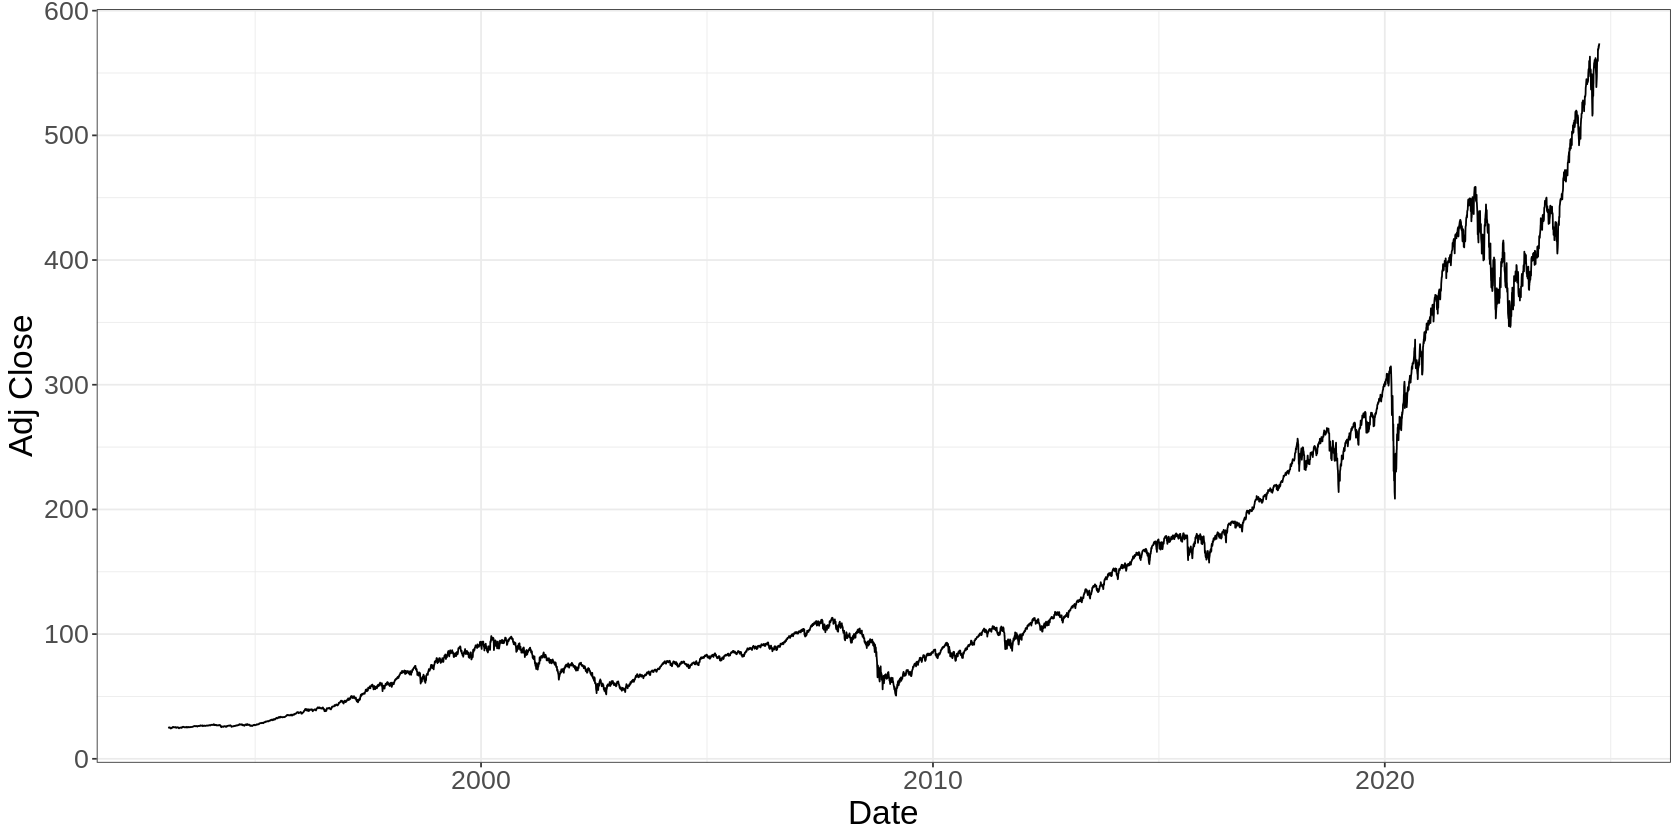

In [25]:
SPY %>%
  ggplot(aes(x=Date, y=`Adj Close`)) + geom_line()

You can see clearly that SPY adjusted close price is not stationary (which is why we often work with returns, as we'll see in the next session.)

In [27]:
# SPX %>%
#   mutate(yearmonth = year(Date) %)

## Understanding bias in our data

SPY is an ETF, not the index.

This won't impact anything really. The noise in our analysis is FAR greater than any difference this will cause.

# Calculating Realized SPY volatility

First we need to calculate realized SPY volatility.

First thing we need to do is calculate returns.

Let's calculate log returns as `log(close / close_the_day_before)`

Our observations are in order of date descending... so we can calculate returns as `log(close / lag(close))`



In [28]:
SPY <- SPY %>%
  arrange(Date) %>%
  mutate(lag_close = lag(Close)) %>%
  mutate(log_returns = log(Close / lag(Close)))

In [29]:
SPY %>% head()

,Date,Open,High,Low,Close,Volume,Adj Close,lag_close,log_returns
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1993-01-29,43.96875,43.96875,43.75000,43.93750,1003200,24.60862,NA,NA
2,1993-02-01,43.96875,44.25000,43.96875,44.25000,480500,24.78366,43.93750,0.0070872019
3,1993-02-02,44.21875,44.37500,44.12500,44.34375,201300,24.83617,44.25000,0.0021164029
4,1993-02-03,44.40625,44.84375,44.37500,44.81250,529400,25.09869,44.34375,0.0105153440
5,1993-02-04,44.96875,45.09375,44.46875,45.00000,531500,25.20371,44.81250,0.0041753714
6,1993-02-05,44.96875,45.06250,44.71875,44.96875,492100,25.18621,45.00000,-0.0006946857




Now we want to calculate realized volatility for a given month (to compare to implied at the start of the month)

For each month, we want the realized volatility.

We can use the lubridate `floor_date` function to get the first calendar date of each calendar month.

In [30]:
RV <- SPY %>%
  mutate(yearmonth = floor_date(Date, 'month')) %>%
  group_by(yearmonth) %>%
  summarise(
    first_trading_date = min(Date), # Needed to align with VIX data
    RV = sd(log_returns) * sqrt(252) * 100 # After computing daily volatility with 30 days of data, annualize
  ) %>%
  na.omit()

RV %>% head()

yearmonth,first_trading_date,RV
<date>,<date>,<dbl>
1993-02-01,1993-02-01,12.748670
1993-03-01,1993-03-01,11.508981
1993-04-01,1993-04-01,11.755824
1993-05-01,1993-05-03,11.150385
1993-06-01,1993-06-01,10.465874
1993-07-01,1993-07-01,8.000993


In [31]:
RV %>% tail()

yearmonth,first_trading_date,RV
<date>,<date>,<dbl>
2024-04-01,2024-04-01,13.201441
2024-05-01,2024-05-01,9.472818
2024-06-01,2024-06-03,6.693322
2024-07-01,2024-07-01,14.390321
2024-08-01,2024-08-01,19.154485
2024-09-01,2024-09-03,13.785698


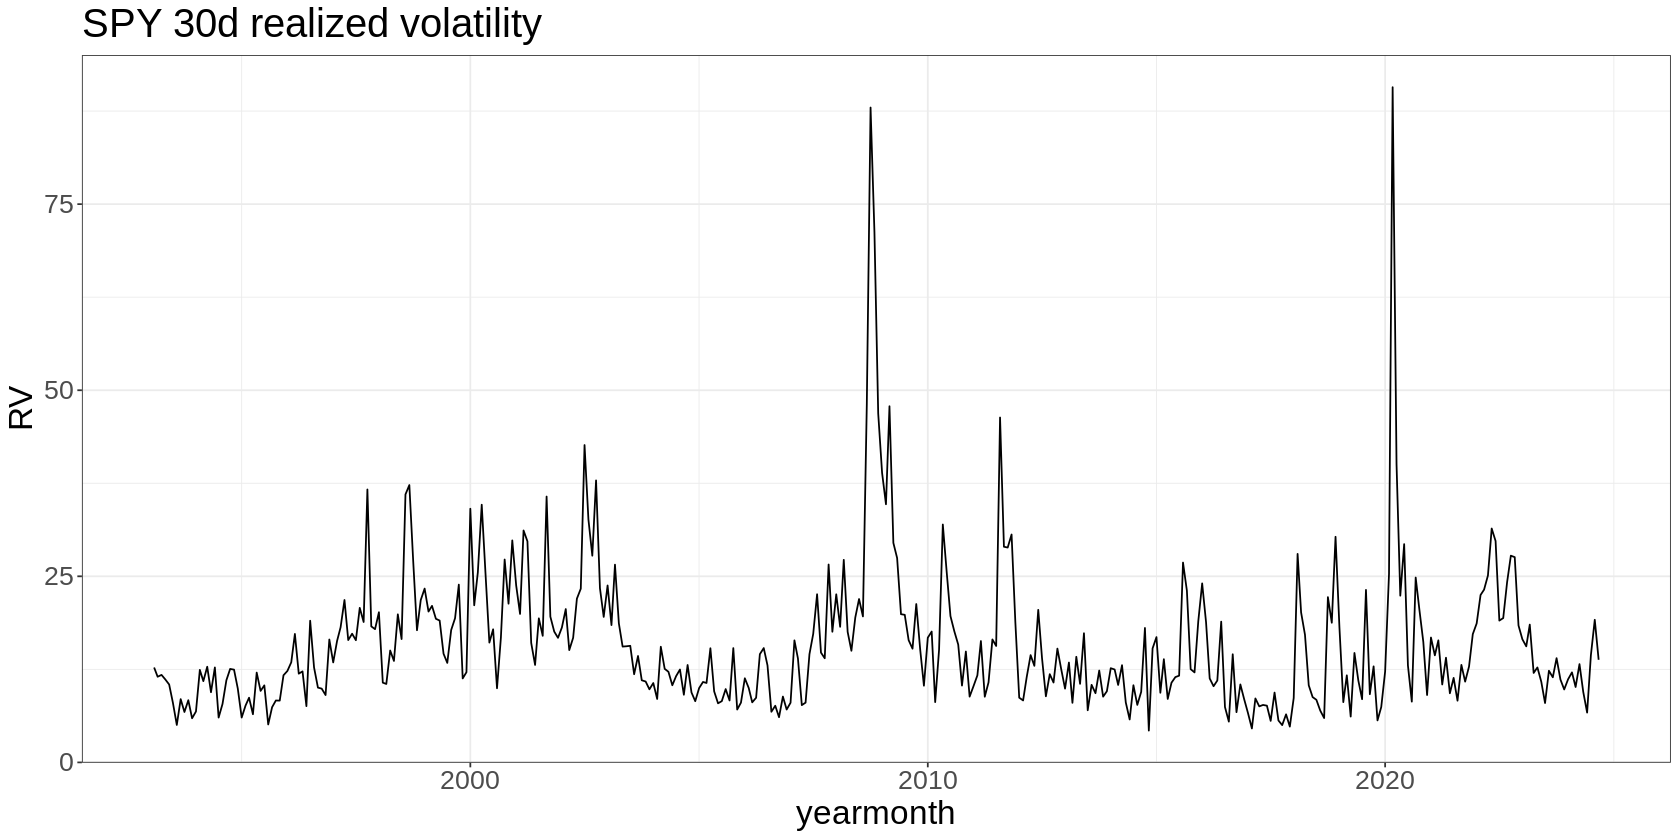

In [32]:
RV %>%
  ggplot(aes(x=yearmonth, y=RV)) + geom_line() + ggtitle('SPY 30d realized volatility')

Now we can group by this and calculate the realized volatility in that month.

Remember to think about what this does to the shape your data.

It makes it shorter, and each row is now a monthly summary rather than a daily observation.

# Do the Initial Analysis

Now we want to join the VIX reading at the start of the month to the realized vol in that month.

In [33]:
VIX %>% tail()

DATE,OPEN,HIGH,LOW,CLOSE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
10/01/2024,16.96,20.73,16.61,19.26
10/02/2024,19.65,20.36,18.58,18.90
10/03/2024,19.63,20.75,19.16,20.49
10/04/2024,20.48,20.48,18.48,19.21
10/07/2024,20.76,23.03,20.65,22.64
10/08/2024,22.92,23.14,21.14,21.42


In [34]:
RV %>% tail()

yearmonth,first_trading_date,RV
<date>,<date>,<dbl>
2024-04-01,2024-04-01,13.201441
2024-05-01,2024-05-01,9.472818
2024-06-01,2024-06-03,6.693322
2024-07-01,2024-07-01,14.390321
2024-08-01,2024-08-01,19.154485
2024-09-01,2024-09-03,13.785698


In [38]:
VRP <- RV %>%
  left_join(VIX, b=c('first_trading_date' = 'DATE')) %>%
  mutate(
    VIX = CLOSE,
    VRP = VIX - RV,
    VRP_pct = log(VIX/RV)
  ) %>%
  select(yearmonth, VIX, RV, VRP, VRP_pct)

In [39]:
VRP %>% head()

yearmonth,VIX,RV,VRP,VRP_pct
<date>,<dbl>,<dbl>,<dbl>,<dbl>
1993-02-01,12.33,12.748670,-0.4186695,-0.0333916
1993-03-01,13.60,11.508981,2.0910191,0.1669421
1993-04-01,13.02,11.755824,1.2641761,0.1021379
1993-05-01,12.90,11.150385,1.7496148,0.1457533
1993-06-01,13.67,10.465874,3.2041263,0.2670838
1993-07-01,11.51,8.000993,3.5090074,0.3636506


Check for NAs

Plot the time series

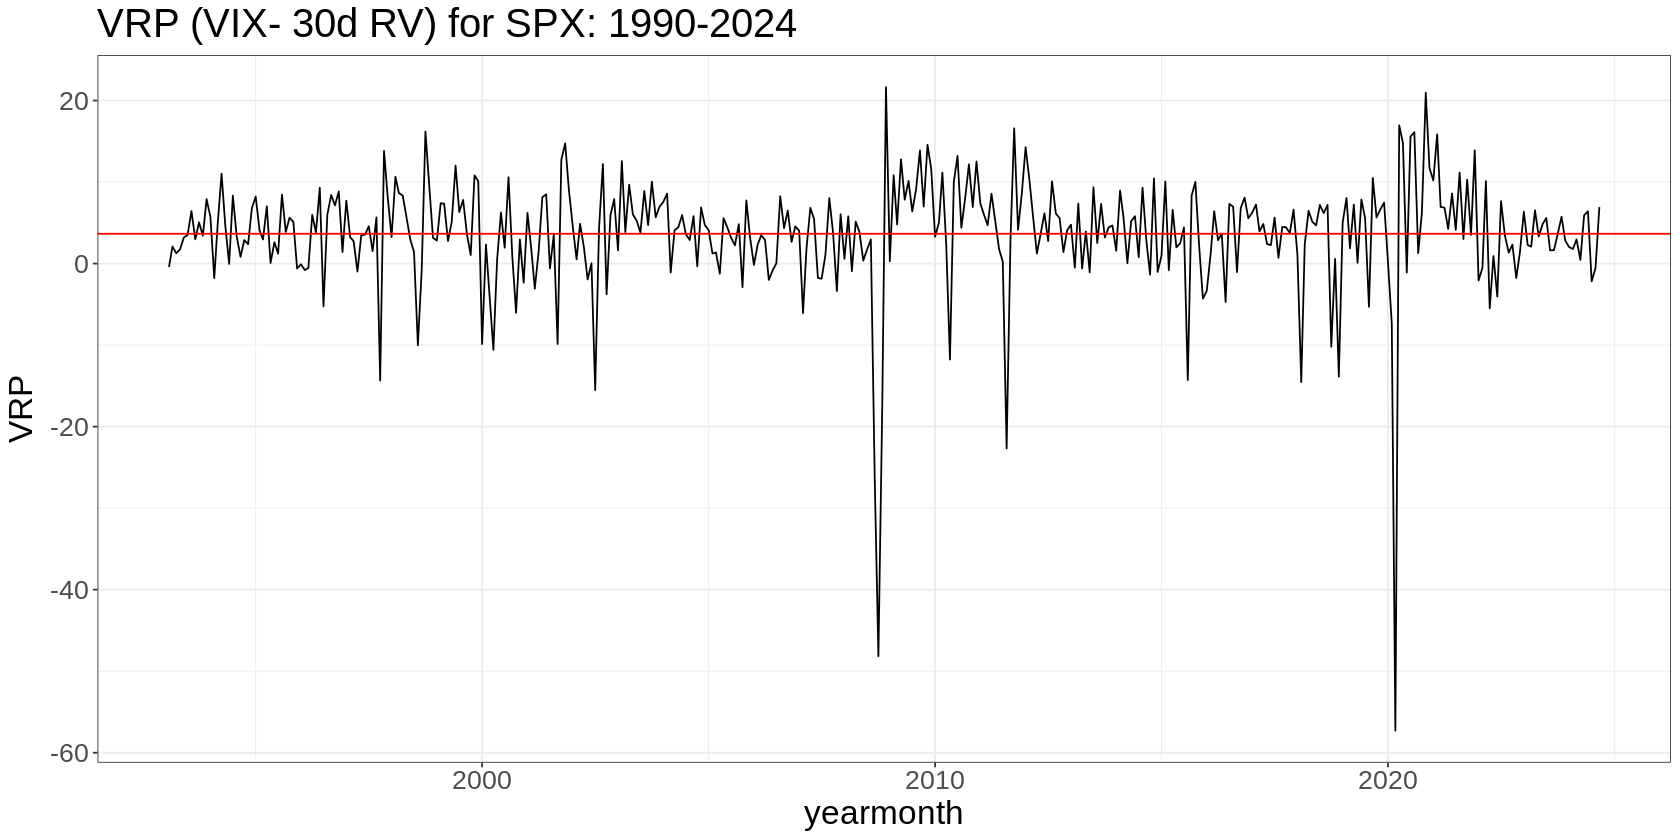

In [40]:
VRP %>%
  ggplot(aes(x=yearmonth, y=VRP)) + geom_line() + geom_hline(yintercept = VRP %>% summarize(mean(VRP)) %>% pull(), color='red') +
  ggtitle('VRP (VIX- 30d RV) for SPX: 1990-2024')

In [41]:
install.packages('roll')
library(roll)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppParallel’, ‘RcppArmadillo’




Warning message:
“Removed 11 rows containing missing values or values outside the scale range
(`geom_line()`).”


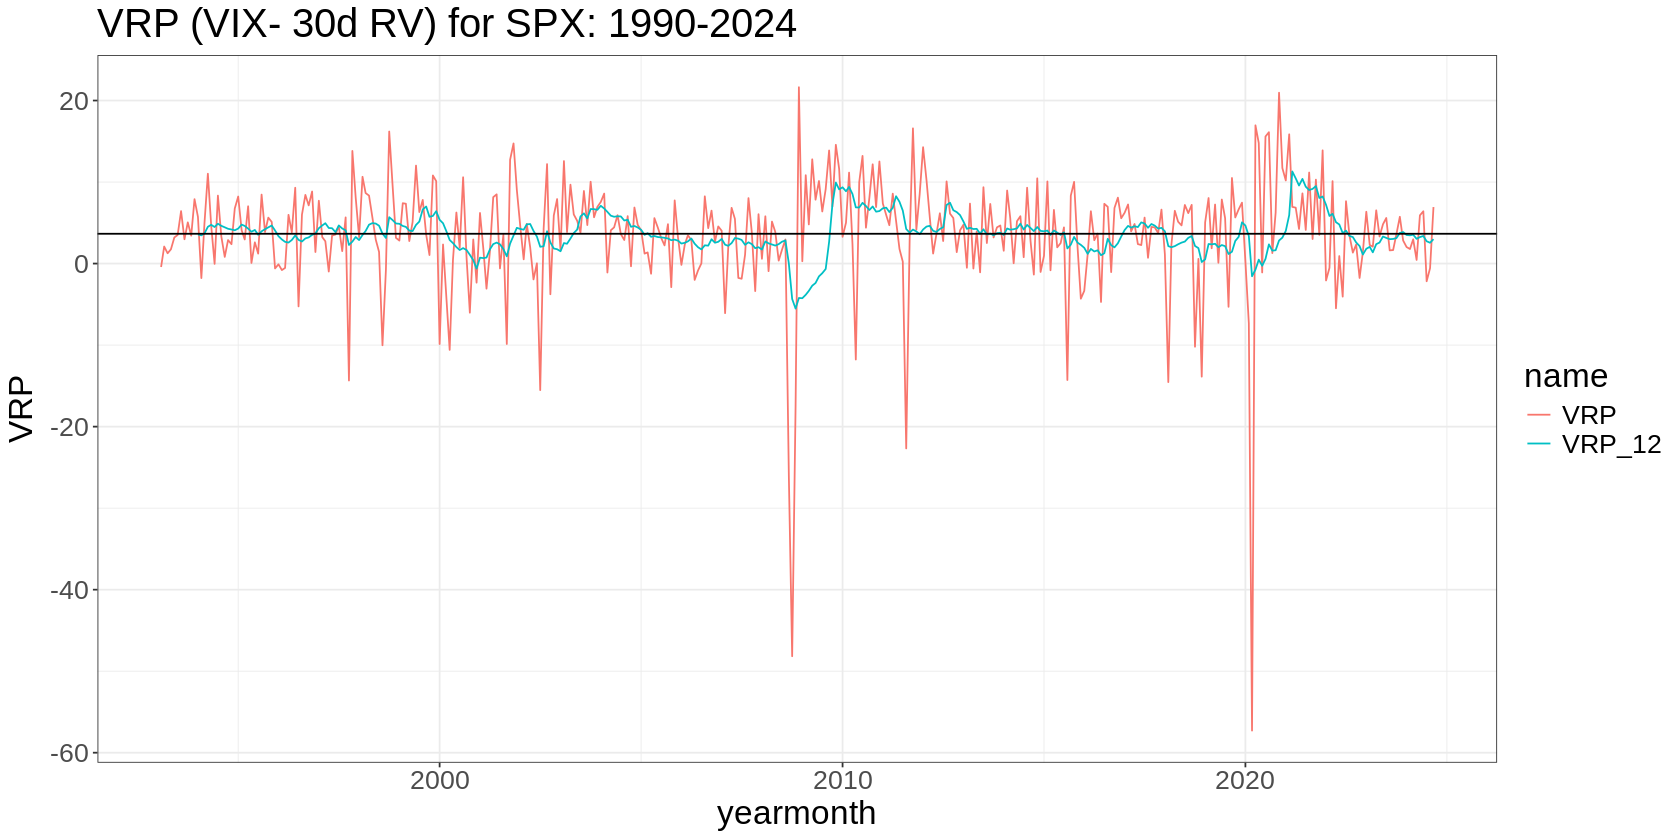

In [42]:
VRP %>%
  mutate(VRP_12 = roll::roll_mean(VRP,12)) %>%
  pivot_longer(c(VRP, VRP_12), values_to = 'VRP') %>%
  ggplot(aes(x=yearmonth, y=VRP, color = name)) + geom_line() + geom_hline(yintercept = VRP %>% summarize(mean(VRP)) %>% pull(), color='black') +
  ggtitle('VRP (VIX- 30d RV) for SPX: 1990-2024')


Warning message:
“Removed 11 rows containing missing values or values outside the scale range
(`geom_line()`).”


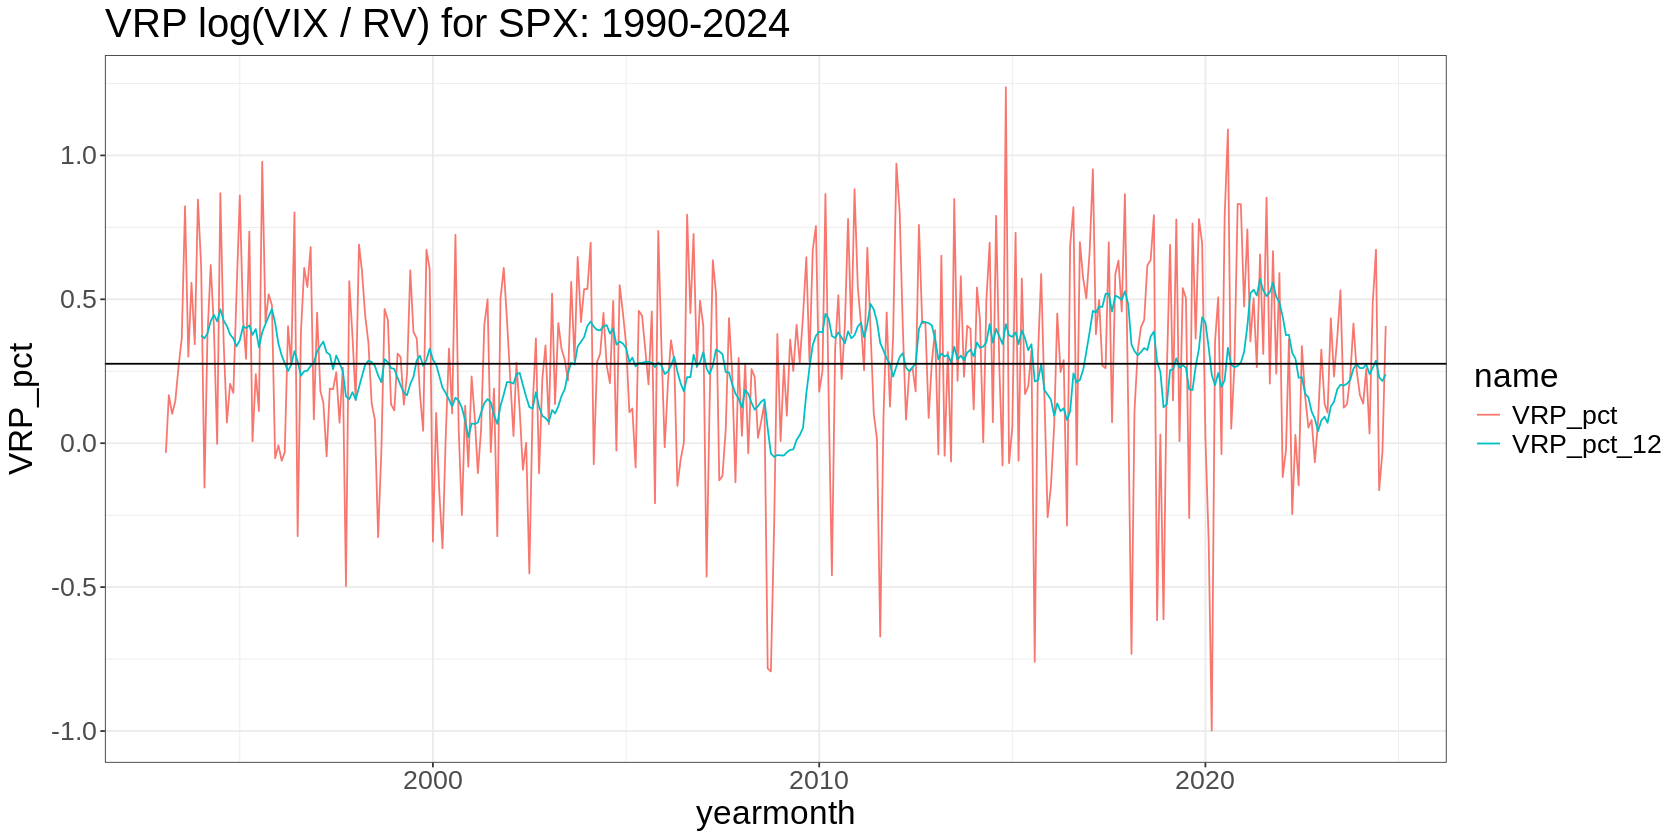

In [43]:
VRP %>%
  mutate(VRP_pct_12 = roll::roll_mean(VRP_pct,12)) %>%
  pivot_longer(c(VRP_pct, VRP_pct_12), values_to = 'VRP_pct') %>%
  ggplot(aes(x=yearmonth, y=VRP_pct, color=name)) + geom_line() + geom_hline(yintercept = VRP %>% summarize(mean(VRP_pct)) %>% pull(), color = 'black') +
  ggtitle('VRP log(VIX / RV) for SPX: 1990-2024')

Plot the distribution

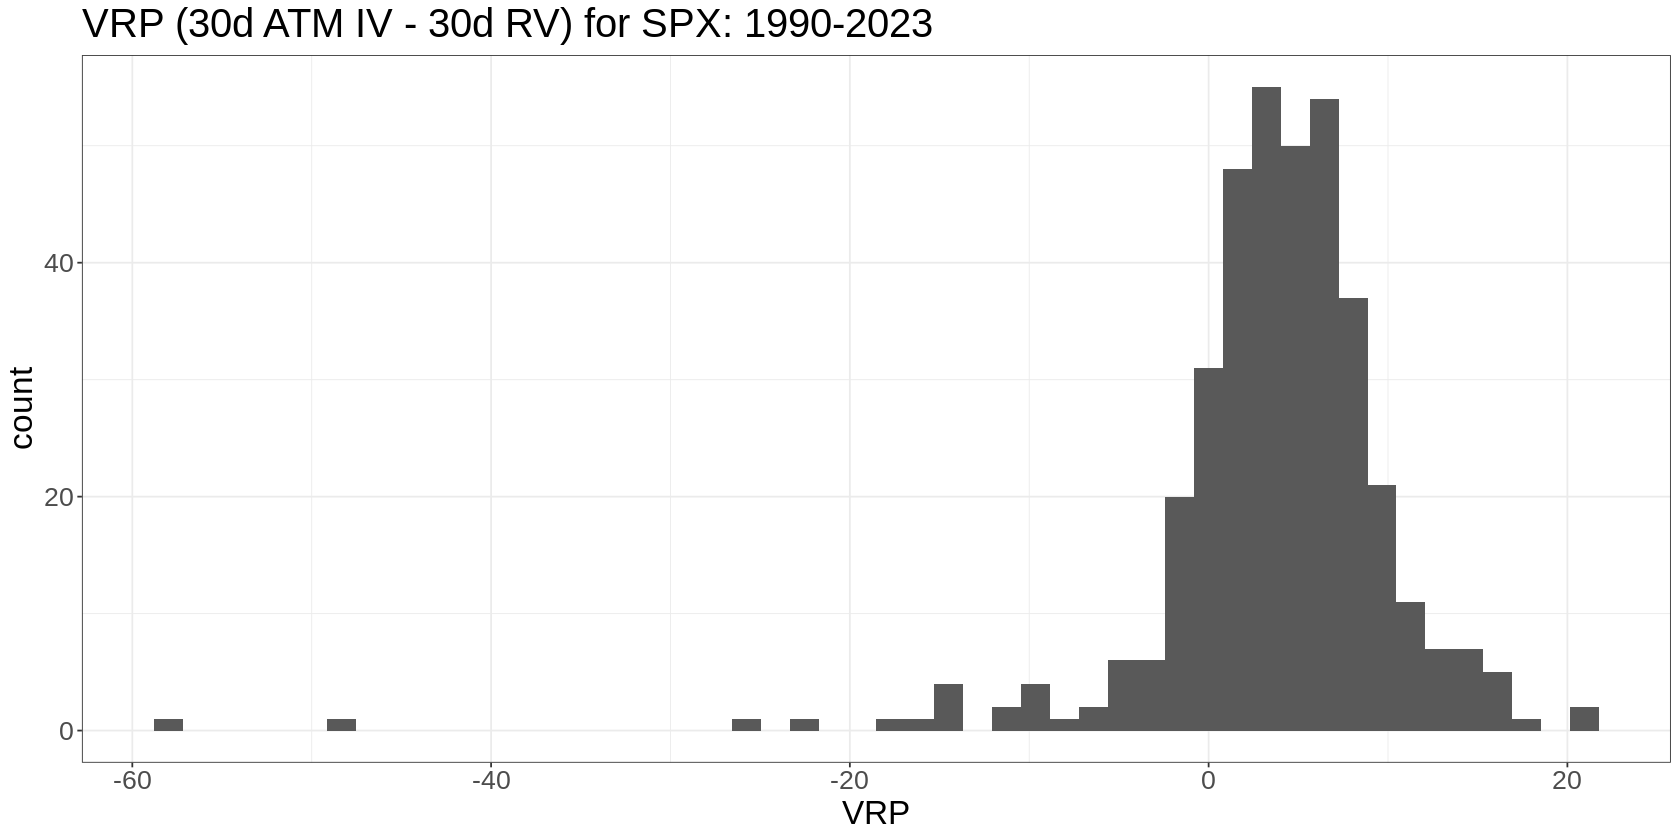

In [44]:
VRP %>%
  ggplot(aes(x=VRP)) +
  geom_histogram(bins=50) +
  ggtitle('VRP (30d ATM IV - 30d RV) for SPX: 1990-2023')

Plot a scatterplot of the VRP against its value the previous month (`lag(VRP)`)

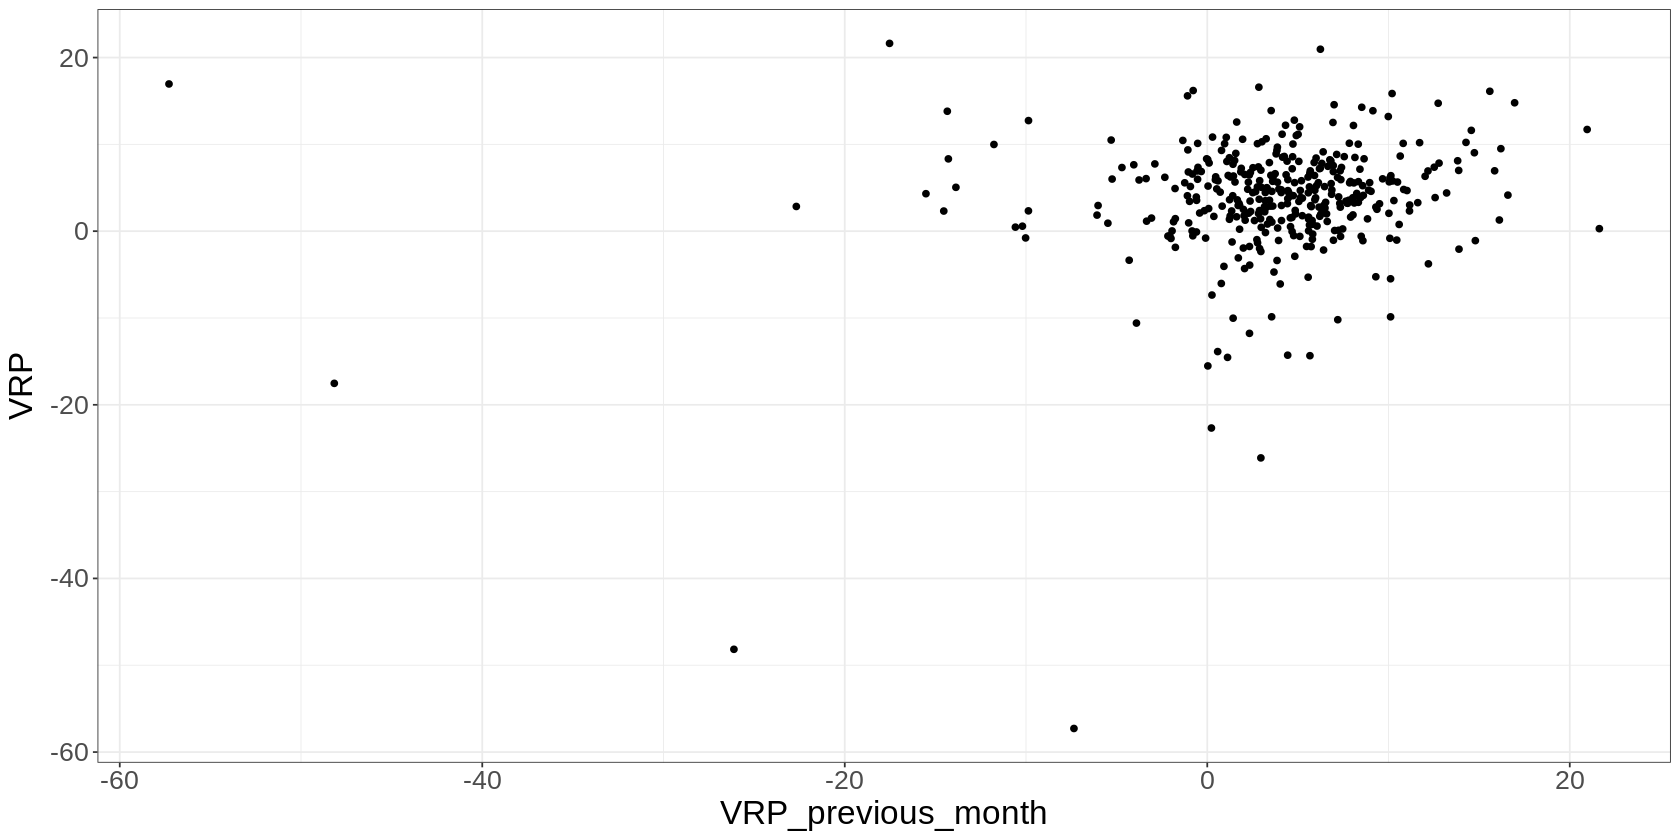

In [45]:
VRP %>%
 mutate(VRP_previous_month = lag(VRP)) %>%
 na.omit() %>%
 ggplot(aes(x=VRP_previous_month, y=VRP)) +
  geom_point()

Add linear regression.

`geom_smooth()` using formula = 'y ~ x'


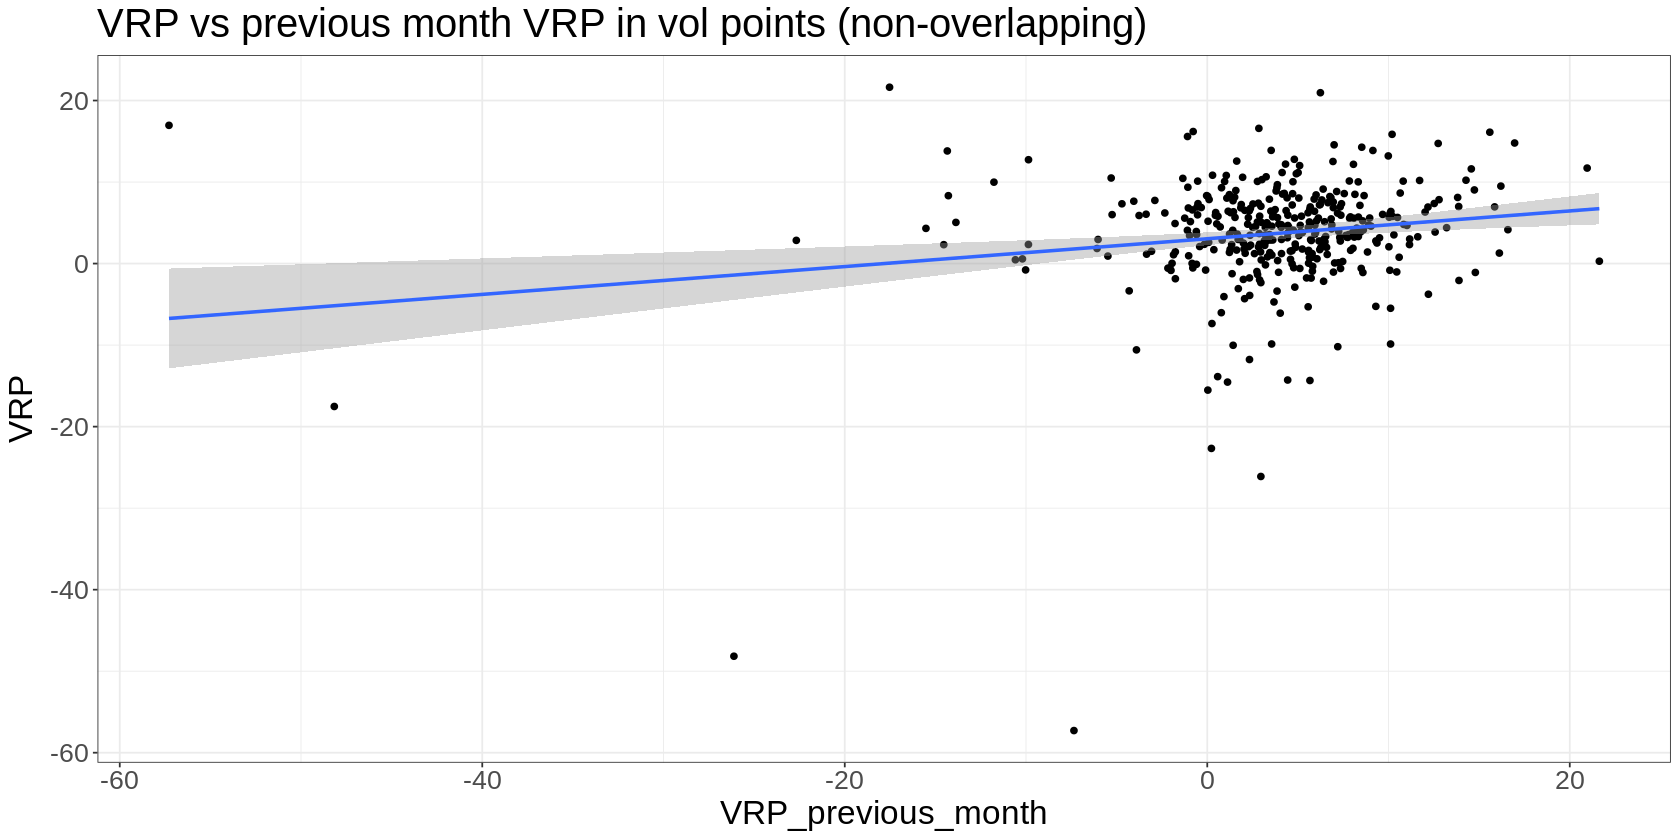

In [46]:
VRP %>%
 mutate(VRP_previous_month = lag(VRP)) %>%
 na.omit() %>%
 ggplot(aes(x=VRP_previous_month, y=VRP)) +
  geom_point() +
  geom_smooth(method = 'lm') +
  ggtitle('VRP vs previous month VRP in vol points (non-overlapping)')

`geom_smooth()` using formula = 'y ~ x'


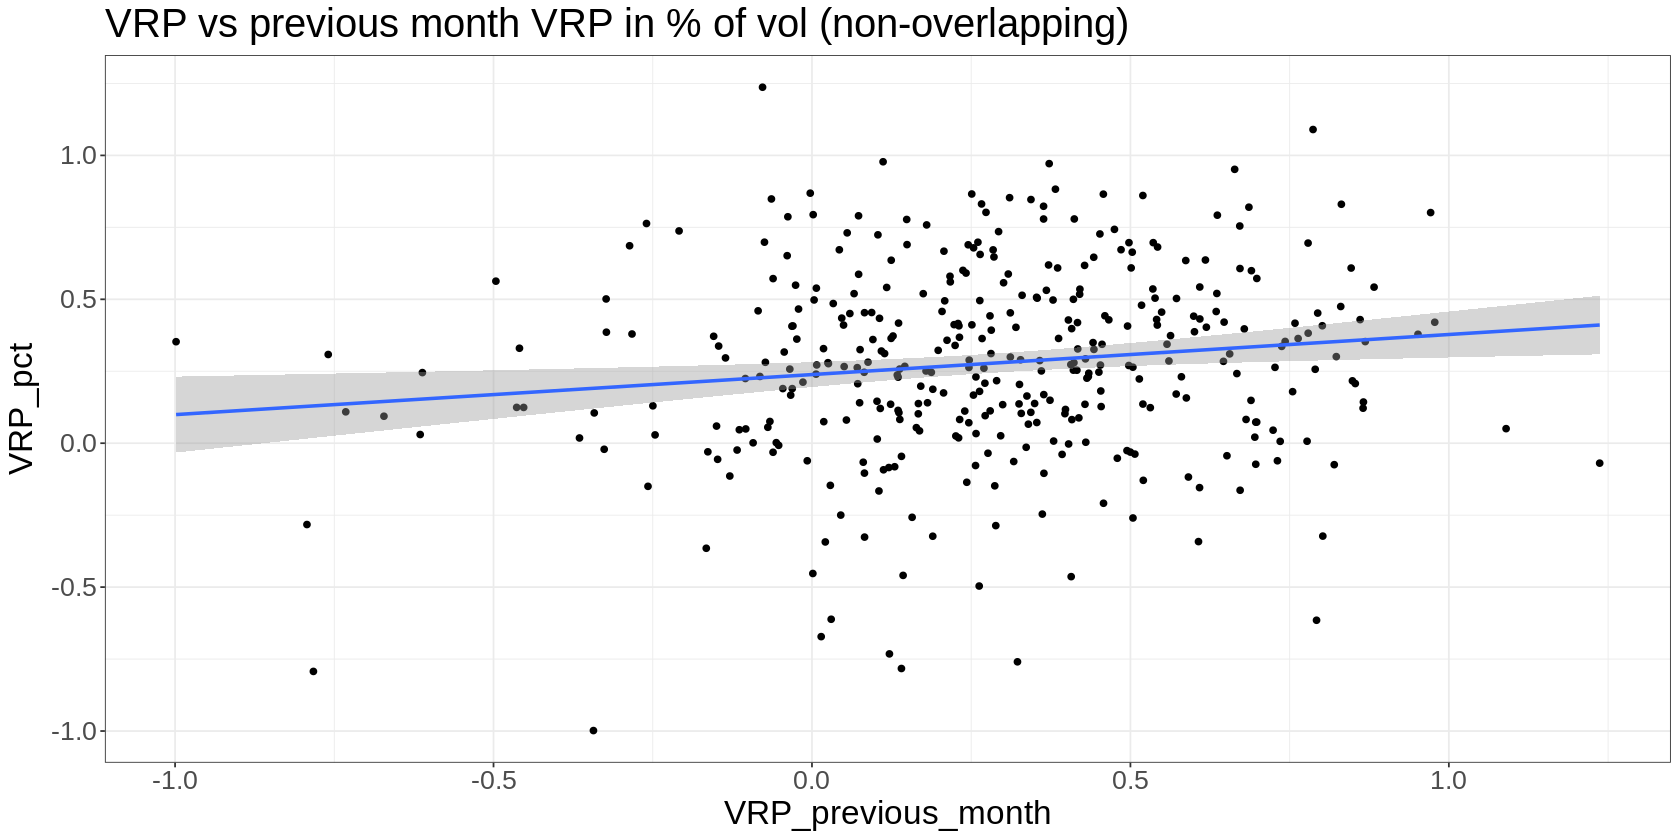

In [47]:
VRP %>%
 mutate(VRP_previous_month = lag(VRP_pct)) %>%
 na.omit() %>%
 ggplot(aes(x=VRP_previous_month, y=VRP_pct)) +
  geom_point() +
  geom_smooth(method = 'lm') +
  ggtitle('VRP vs previous month VRP in % of vol (non-overlapping)')

In [48]:
head(VRP)

yearmonth,VIX,RV,VRP,VRP_pct
<date>,<dbl>,<dbl>,<dbl>,<dbl>
1993-02-01,12.33,12.748670,-0.4186695,-0.0333916
1993-03-01,13.60,11.508981,2.0910191,0.1669421
1993-04-01,13.02,11.755824,1.2641761,0.1021379
1993-05-01,12.90,11.150385,1.7496148,0.1457533
1993-06-01,13.67,10.465874,3.2041263,0.2670838
1993-07-01,11.51,8.000993,3.5090074,0.3636506


Plot lagged auto-correlations

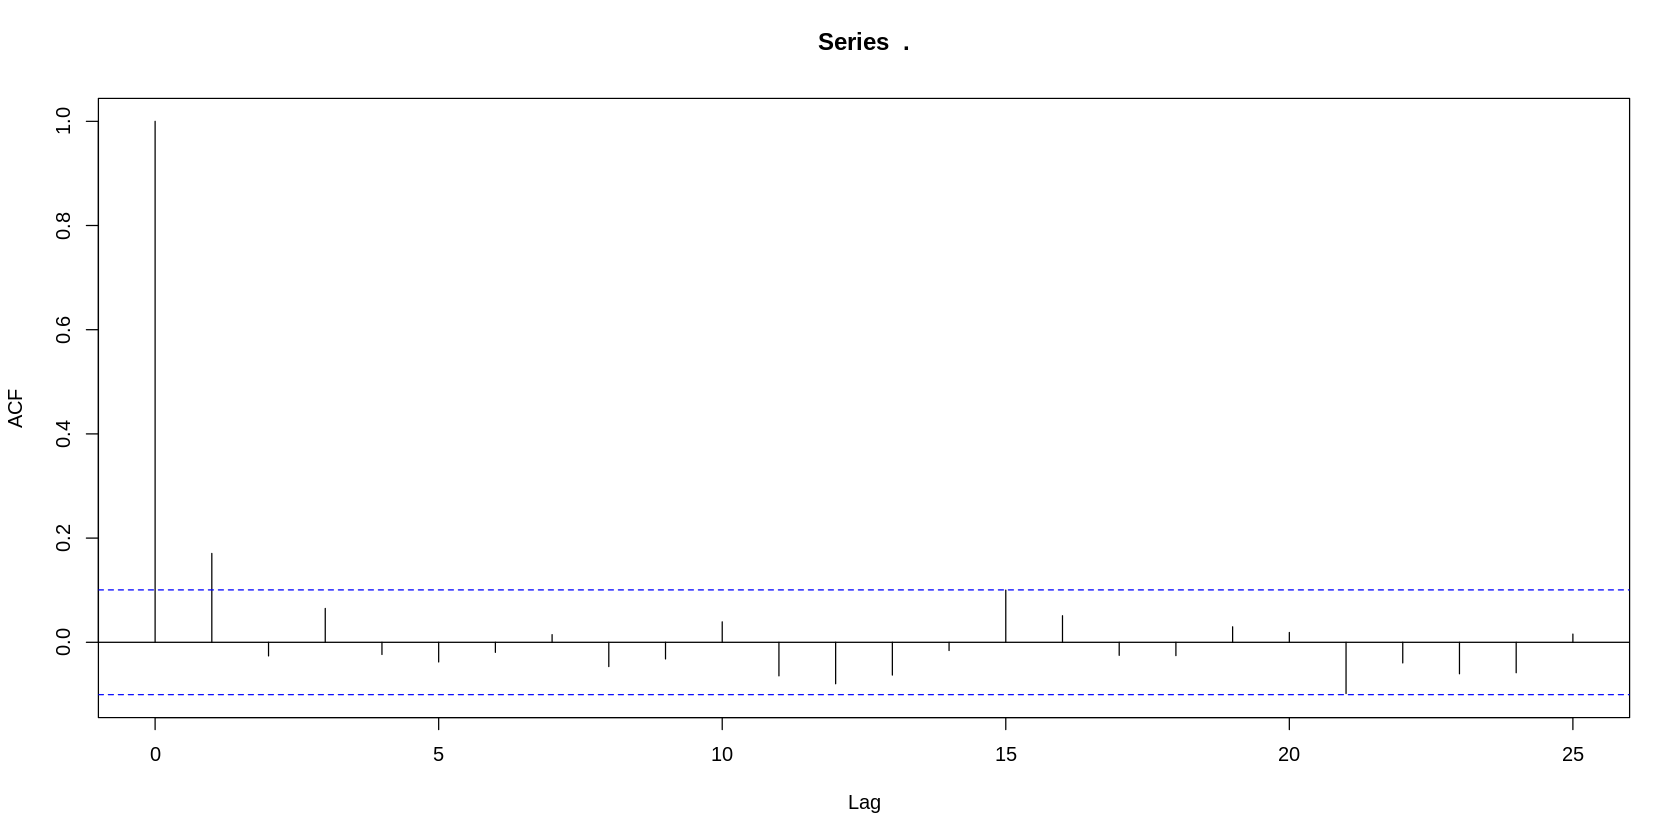

In [49]:
VRP %>%
  pull(VRP) %>%
  acf()

Now look at it with the extreme values pulled out

In [50]:
VRP_benign  <- VRP %>%
  mutate(lag_VRP = lag(VRP)) %>%
  filter(abs(lag_VRP) < 10)

`geom_smooth()` using formula = 'y ~ x'


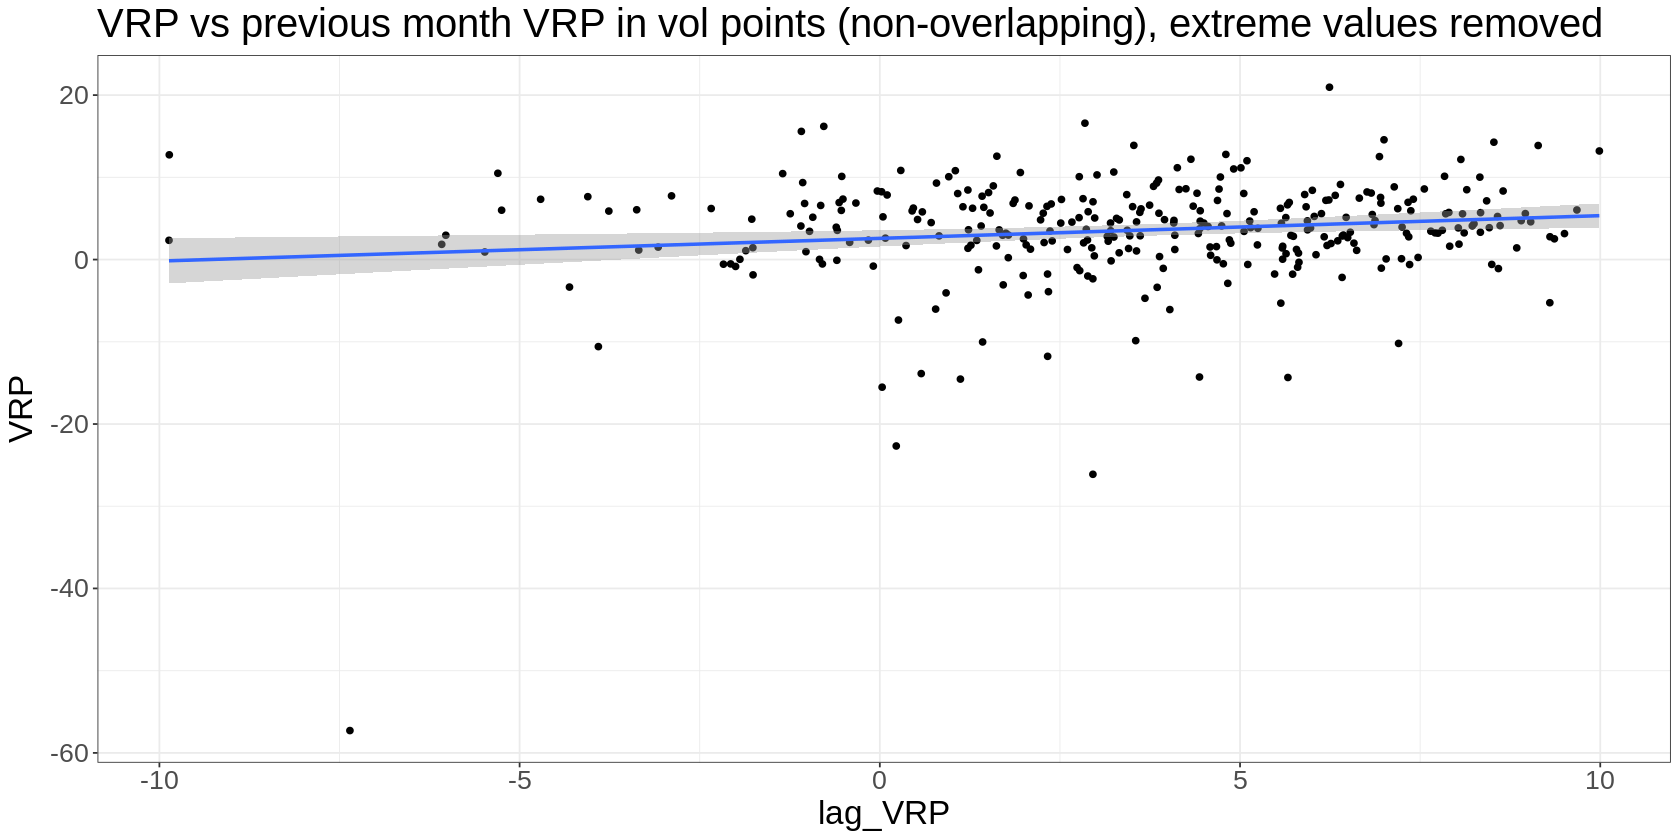

In [53]:
VRP_benign %>%
 na.omit() %>%
 ggplot(aes(x=lag_VRP, y=VRP)) +
  geom_point() +
  geom_smooth(method = 'lm') +
  ggtitle('VRP vs previous month VRP in vol points (non-overlapping), extreme values removed')

There's a bit left there, even after removing extreme observations.

Now look at how consistent the effect is over the time period

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


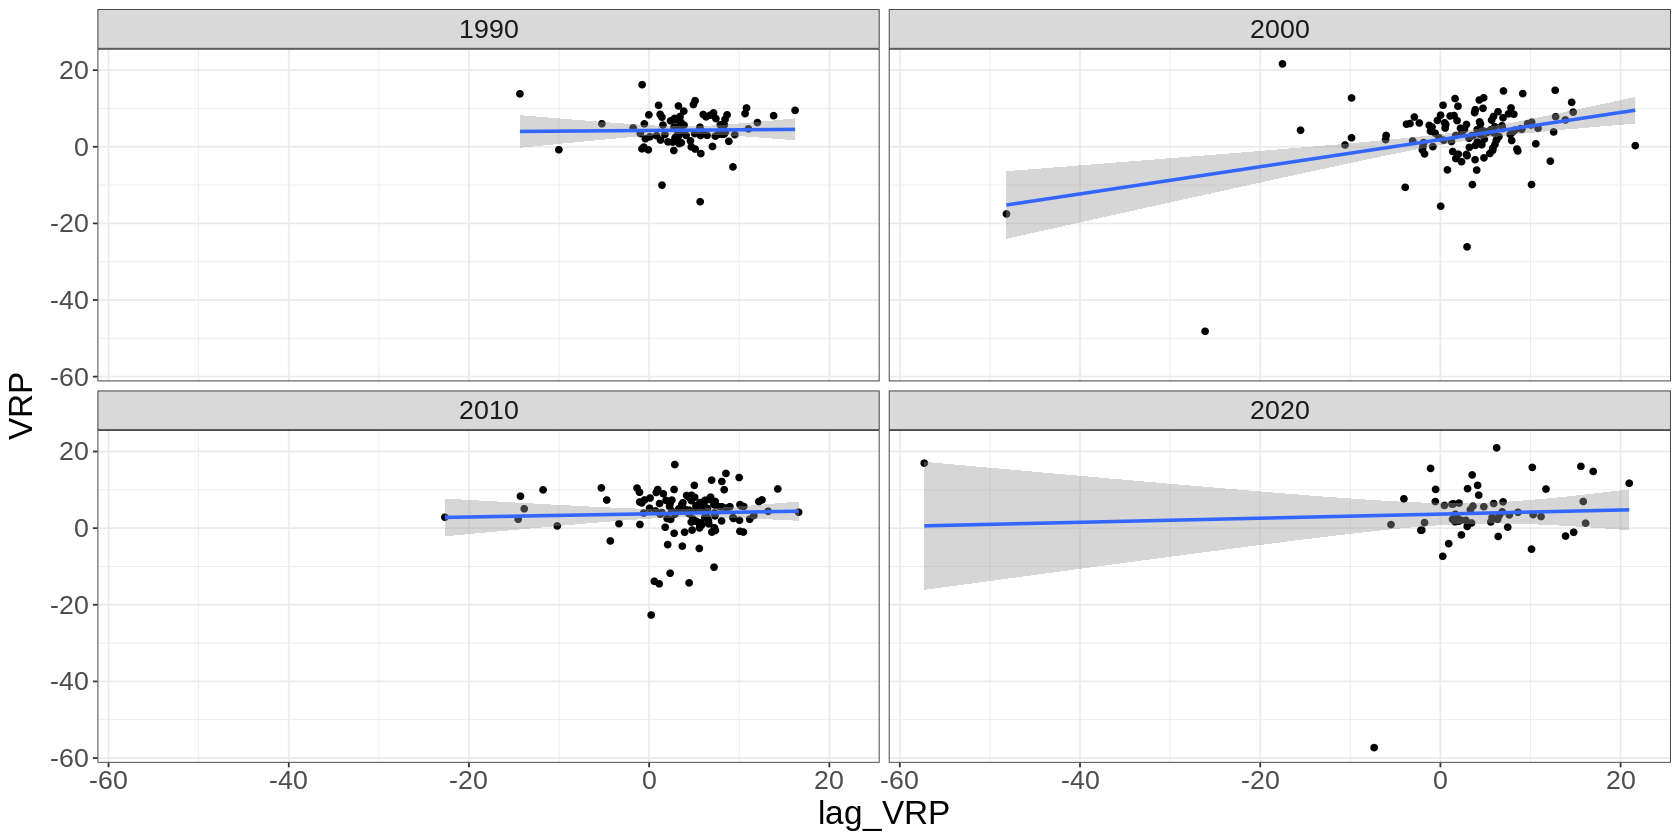

In [52]:
VRP %>%
  mutate(decade = year(yearmonth) - year(yearmonth) %% 10) %>%
  mutate(lag_VRP = lag(VRP)) %>%
  ggplot(aes(x=lag_VRP, y=VRP)) +
    geom_point() +
    geom_smooth(method = 'lm') +
    facet_wrap(~decade)

# Summmary

We haven't discounted the trader wisdom.

There does seem to be a weak effect in the data - but it seems to be concentrated in 2000's.

Next questions:

What else would explain this?
* we may have made a mistake (overlapping data etc)
* luck or calendar effects - we used calendar months